# Feature Engineering and Preprocessing 

### Import Libraries

In [1]:
import sys
import os
from dotenv import load_dotenv
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(".."))

# Specify the path to your .env file
env_path = '..\\.env'
# Load the .env file from the specified path
load_dotenv(env_path)
sys.path.append(os.path.abspath(os.getenv('ADVANCED_COMMON_LIBRARY_PATH')))
sys.path.append(os.path.abspath(os.getenv('BEGINNERS_COMMON_LIBRARY_PATH')))


from common.load_data import load_data
from common.chronological_split import chronological_train_test_split
from utils.cyclical_time_features import add_cyclical_time_features
from utils.scale_continious_features import scale_continious_features
from utils.lookback_windows import create_lookback_windows
from utils.time_series_dataset import TimeSeriesDataset


### Pipeline
- Load data
- scale features
- add cyclical time features
- chronologically split data

In [2]:
# Load and preprocess data
sc = StandardScaler()

dataset = (
    load_data(file_path=os.getenv('DATA_FILE'))
    .pipe(
        scale_continious_features,
        continious_cols=[
            'Temperature', 'Humidity', 'Wind Speed',
            'general diffuse flows', 'diffuse flows',
            'Zone 1 Power Consumption', 'Zone 2 Power Consumption', 'Zone 3 Power Consumption'
        ],
        scaler=sc
    )
    .pipe(add_cyclical_time_features)
)

dataset_train, dataset_val, dataset_test = chronological_train_test_split(dataset, train_ratio=0.7, val_ratio=0.15)

[INFO] Using 'DateTime' as datetime index column


### Lookback Windows

In [3]:
# For 2-hour loopback (12 steps), 24-hour lookback (144 steps) and 1-hour prediction (6 steps)
lookback = 144      # last 24 hours
predict_next = 6    # next 1 hour
zones = ['Zone 1 Power Consumption', 'Zone 2 Power Consumption', 'Zone 3 Power Consumption']
dataloader_dict = {}
batch_size = 64
seq2one_data = {'train': {}, 'val': {}, 'test': {}} # for plotting later

for zone in zones:
    zone_data = {}

   # Create lookback windows for train
    X_train, y_train = create_lookback_windows(
        dataset_train, target_cols=[zone], lookback=lookback, predict_next=predict_next, seq_type='seq2one'
    )

    # Create lookback windows for train
    X_val, y_val = create_lookback_windows(
        dataset_val, target_cols=[zone], lookback=lookback, predict_next=predict_next, seq_type='seq2one'
    )

    # Create lookback windows for test
    X_test, y_test = create_lookback_windows(
        dataset_test, target_cols=[zone], lookback=lookback, predict_next=predict_next, seq_type='seq2one'
    )

    seq2one_data['train'][zone] = create_lookback_windows(dataset_train, [zone], lookback, seq_type='seq2one')
    seq2one_data['val'][zone] = create_lookback_windows(dataset_val, [zone], lookback, seq_type='seq2one')
    seq2one_data['test'][zone] = create_lookback_windows(dataset_test, [zone], lookback, seq_type='seq2one')

    # Create datasets
    train_dataset = TimeSeriesDataset(X_train, y_train)
    val_dataset = TimeSeriesDataset(X_val, y_val)
    test_dataset = TimeSeriesDataset(X_test, y_test)

    # Wrap in DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    dataloader_dict[zone] = {
        'train_loader': train_loader,
        'val_loader': val_loader,
        'test_loader': test_loader
    }




In [4]:
import matplotlib.pyplot as plt
import numpy as np

def plot_lookback_example(X, y, zone="Zone", seq_type="seq2one", lookback=144, predict_next=12, idx=0):
    """
    Plot an example lookback window and target(s) for seq2one or seq2seq.

    Parameters
    ----------
    X : np.ndarray
        Input sequences, shape (samples, lookback, features).
    y : np.ndarray
        Targets, shape (samples,) for seq2one
                 (samples, predict_next, 1) for seq2seq.
    seq_type : str
        "seq2one" or "seq2seq".
    lookback : int
        Number of past steps.
    predict_next : int
        Number of future steps (only for seq2seq).
    idx : int
        Index of the sample to plot.
    zone : str
        Zone name for labeling.
    """
    plt.figure(figsize=(8,4))

    # Plot lookback sequence (last 2 hours in your case)
    plt.plot(range(lookback), X[idx, :, 0], marker="o", label="Lookback (past values)", color="blue")

    if seq_type == "seq2one":
        # Plot the next step
        plt.scatter(lookback, y[idx], color="red", label="Target (next step)")
    elif seq_type == "seq2seq":
        # Plot multiple future steps
        future_steps = np.arange(lookback, lookback + predict_next)
        plt.scatter(future_steps, y[idx, :, 0], color="red", label="Targets (future horizon)")

    plt.title(f"{zone} | {seq_type} example")
    plt.xlabel("Time steps")
    plt.ylabel("Normalized consumption")
    plt.legend()
    plt.grid(True)
    plt.show()


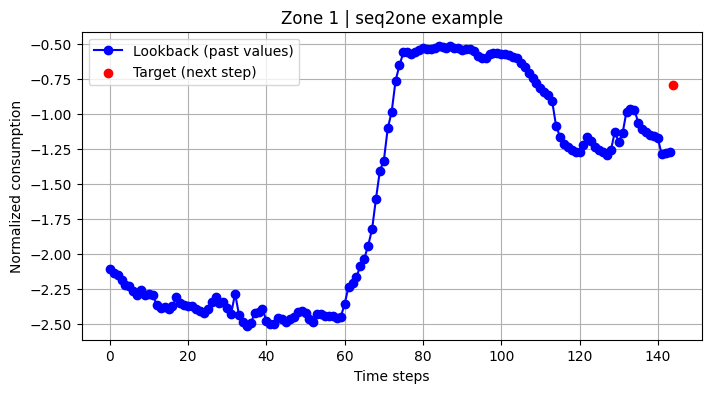

In [5]:
plot_lookback_example(seq2one_data['train']['Zone 1 Power Consumption'][0],
                      seq2one_data['train']['Zone 1 Power Consumption'][1],
                      zone='Zone 1', lookback=lookback, predict_next=predict_next)

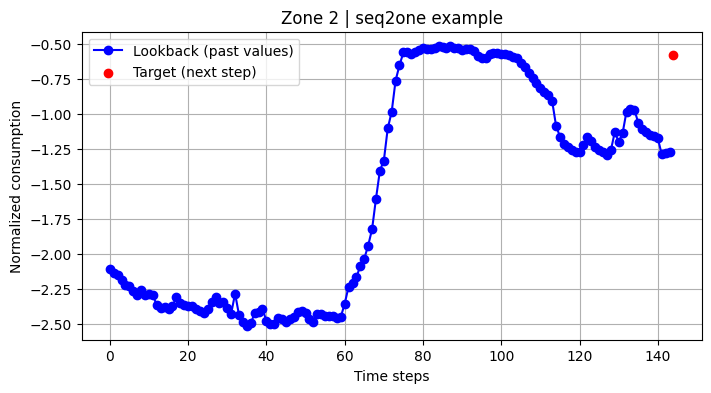

In [6]:
plot_lookback_example(seq2one_data['train']['Zone 2 Power Consumption'][0],
                      seq2one_data['train']['Zone 2 Power Consumption'][1],
                      zone='Zone 2', lookback=lookback, predict_next=predict_next)

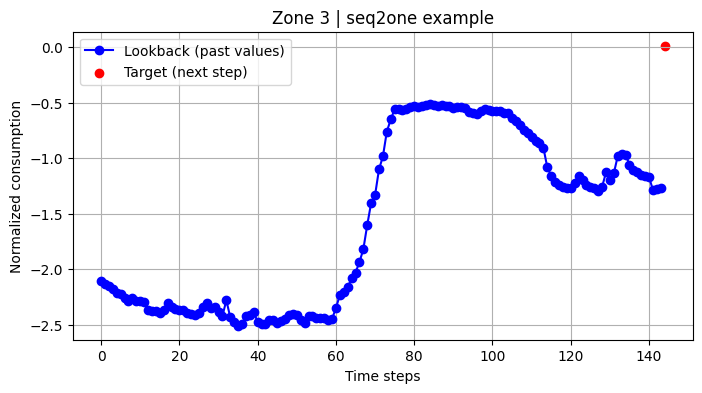

In [7]:
plot_lookback_example(seq2one_data['train']['Zone 3 Power Consumption'][0],
                      seq2one_data['train']['Zone 3 Power Consumption'][1],
                      zone='Zone 3', lookback=lookback, predict_next=predict_next)